In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt


SEED = 42
np.random.seed(SEED)
tf.set_random_seed(SEED)

/home/redanalyze/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/redanalyze/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/redanalyze/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/redanalyze/anaconda3/lib/python3.6/site-packages/tensorflow/pyth

In [2]:
dataset = pd.read_csv('../../../data/GH_complete_labeled_issues_prs - preprocessed.csv', encoding='utf-8', 
                      na_filter=False)
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152151 entries, 0 to 152150
Data columns (total 2 columns):
description    152151 non-null object
label          152151 non-null int64
dtypes: int64(1), object(1)
memory usage: 2.3+ MB


In [3]:
from collections import Counter

dataset = dataset[dataset.label != 0]
texts = dataset['description'].tolist()
labels = dataset['label'].tolist()

print('Before:', Counter(labels))
labels = [0 if item == 1 else 1 for item in labels]
print('After:', Counter(labels))

Before: Counter({1: 22572, 2: 671})
After: Counter({0: 22572, 1: 671})


In [4]:
from sklearn.model_selection import train_test_split

train_text, test_text, train_labels, test_labels = train_test_split(texts, labels, 
                                                                    test_size=0.25, random_state=SEED)
len(train_text), len(test_text)

(17432, 5811)

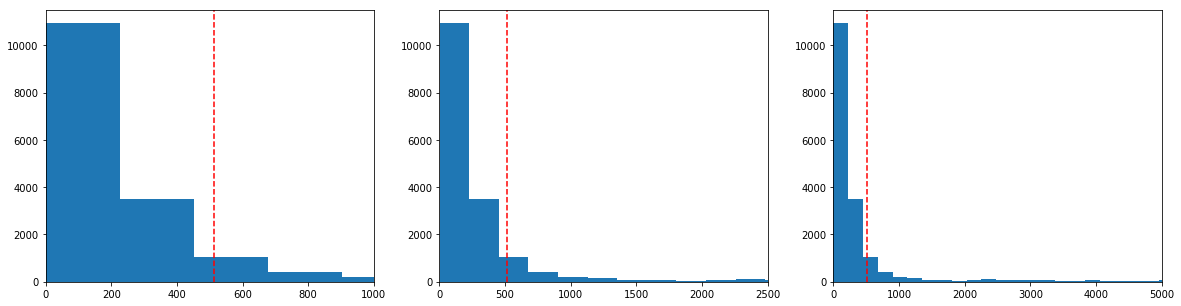

In [5]:
train_doc_lens = [len(doc.split(' ')) for doc in train_text]
f, ax = plt.subplots(1, 3, figsize=(20, 5))

ax[0].hist(train_doc_lens, bins=100)
ax[0].set_xlim([0, 1000])
ax[0].axvline(512, linestyle='--', color='r')

ax[1].hist(train_doc_lens, bins=100)
ax[1].set_xlim([0, 2500])
ax[1].axvline(512, linestyle='--', color='r')

ax[2].hist(train_doc_lens, bins=100)
ax[2].set_xlim([0, 5000])
ax[2].axvline(512, linestyle='--', color='r')

In [6]:
Counter([1 if ln > 512 else 0 for ln in train_doc_lens])

Counter({0: 14826, 1: 2606})

In [7]:
from utils import bert_text_processor as btp

In [8]:
# Initialize session
sess = tf.Session()

# Params for bert model and tokenization
BERT_PATH = "models/model_assets/gokube-phase2/base_bert_tfhub_models/bert_uncased_L12_H768_A12"
MAX_SEQ_LENGTH = 512

In [9]:
# process text data
btp_train = btp.BertTextProcessor(tf_session=sess, 
                                  bert_model_path=BERT_PATH, 
                                  max_seq_length=MAX_SEQ_LENGTH)
btp_train.create_bert_tokenizer()
btp_train.convert_text_to_input_examples(train_text, train_labels)
btp_train.convert_examples_to_features()


btp_test = btp.BertTextProcessor(tf_session=sess, 
                                 bert_model_path=BERT_PATH, 
                                 max_seq_length=MAX_SEQ_LENGTH)
btp_test.create_bert_tokenizer()
btp_test.convert_text_to_input_examples(test_text)
btp_test.convert_examples_to_features()

Loading Base BERT Model
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I1126 19:55:18.530803 140477385926464 tf_logging.py:115] Saver not created because there are no variables in the graph to restore
Converting text to examples: 17432it [00:00, 595802.60it/s]
Converting examples to features:   0%|          | 0/17432 [00:00<?, ?it/s]

Loading BERT WordPiece Tokenizer
Creating Input Examples from data
Creating BERT Input Features from Input Examples


Converting examples to features: 100%|██████████| 17432/17432 [05:24<00:00, 53.72it/s] 


Loading Base BERT Model
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I1126 20:00:48.818341 140477385926464 tf_logging.py:115] Saver not created because there are no variables in the graph to restore
Converting text to examples: 5811it [00:00, 522053.26it/s]
Converting examples to features:   0%|          | 0/5811 [00:00<?, ?it/s]

Loading BERT WordPiece Tokenizer
Creating Input Examples from data
Creating BERT Input Features from Input Examples


Converting examples to features: 100%|██████████| 5811/5811 [01:41<00:00, 57.39it/s] 


In [10]:
from models import bert_cve_classifier as bcvec

In [11]:
# load pre-trained base BERT model
bc = bcvec.BERTClassifier(bert_model_path=BERT_PATH, 
                          max_seq_length=MAX_SEQ_LENGTH)
bc.build_model_architecture()

Build BERT Classifier CVE Model Architecture
Loading Base BERT Model
Trainable layers: 199
Non Trainable layers: 5
Constructing Base BERT architecture
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I1126 20:02:35.163871 140477385926464 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


In [12]:
bc.model_estimator.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          (None, 512)          0                                            
__________________________________________________________________________________________________
input_masks (InputLayer)        (None, 512)          0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        (None, 512)          0                                            
__________________________________________________________________________________________________
bert_layer (BertLayer)          (None, 768)          110104890   input_ids[0][0]                  
                                                                 input_masks[0][0]                
          

In [13]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight('balanced',
                                                  np.unique(btp_train.labels.ravel()),
                                                  btp_train.labels.ravel())
class_weights = dict(enumerate(class_weights))
class_weights[1] *= 2
class_weights

{0: 0.5149474181732246, 1: 34.45059288537549}

In [14]:
modelckpt_cb = tf.keras.callbacks.ModelCheckpoint('bert_cve75_lamb_weights-ep:{epoch:02d}-trn_loss:{loss:.3f}-trn_acc:{acc:.3f}-val_loss:{val_loss:.3f}-val_acc:{val_acc:.3f}.h5', 
                                        save_weights_only=True, period=1, verbose=1)

In [15]:
btp.initialize_vars(sess)

In [16]:
history = bc.model_estimator.fit(x=[btp_train.input_ids, 
                                    btp_train.input_masks, 
                                    btp_train.segment_ids],
                                 y=train_labels,
                                 validation_split=0.1,
                                 epochs=5,
                                 batch_size=15,
                                 class_weight=class_weights,
                                 callbacks=[modelckpt_cb],
                                 verbose=1
)

/home/redanalyze/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 15688 samples, validate on 1744 samples
Epoch 1/5
15675/15688 [============================>.] - ETA: 1s - loss: 0.6992 - acc: 0.8585
Epoch 00001: saving model to bert_cve75_lamb_weights-ep:01-trn_loss:0.700-trn_acc:0.859-val_loss:0.558-val_acc:0.977.h5
15688/15688 [==============================] - 2089s 133ms/step - loss: 0.6997 - acc: 0.8586 - val_loss: 0.5582 - val_acc: 0.9771
Epoch 2/5
15675/15688 [============================>.] - ETA: 1s - loss: 0.6456 - acc: 0.9619
Epoch 00002: saving model to bert_cve75_lamb_weights-ep:02-trn_loss:0.646-trn_acc:0.962-val_loss:0.558-val_acc:0.977.h5
15688/15688 [==============================] - 2047s 130ms/step - loss: 0.6462 - acc: 0.9618 - val_loss: 0.5582 - val_acc: 0.9771
Epoch 3/5
15675/15688 [============================>.] - ETA: 1s - loss: 0.6319 - acc: 0.9549
Epoch 00003: saving model to bert_cve75_lamb_weights-ep:03-trn_loss:0.632-trn_acc:0.955-val_loss:0.570-val_acc:0.977.h5
15688/15688 [==============================] - 20

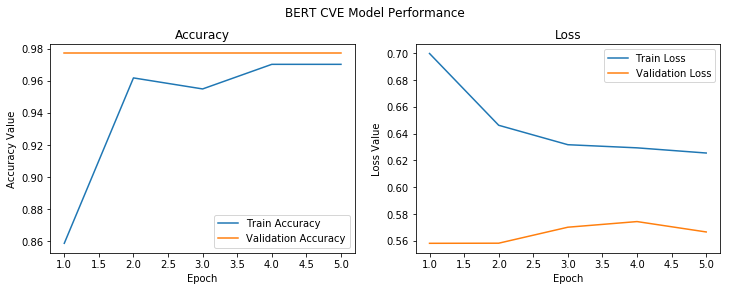

In [28]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('BERT CVE Model Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.2)

epochs = list(range(1,6))
ax1.plot(epochs, history.history['acc'], label='Train Accuracy')
ax1.plot(epochs, history.history['val_acc'], label='Validation Accuracy')
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epochs, history.history['loss'], label='Train Loss')
ax2.plot(epochs, history.history['val_loss'], label='Validation Loss')
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

### Test every epoch on test data set

In [18]:
import gc
del bc
gc.collect()

6225

In [19]:
from sklearn.metrics import confusion_matrix, classification_report

In [21]:
bc = bcvec.BERTClassifier(bert_model_path=BERT_PATH, 
                          max_seq_length=MAX_SEQ_LENGTH)
bc.build_model_architecture()
bc.load_model_weights(model_weights_path='./bert_cve75_lamb_weights-ep:01-trn_loss:0.700-trn_acc:0.859-val_loss:0.558-val_acc:0.977.h5')
test_predictions = bc.model_estimator.predict(x=[btp_test.input_ids, 
                                                 btp_test.input_masks, 
                                                 btp_test.segment_ids],
                                                 batch_size=256,
                                              verbose=1)

Build BERT Classifier CVE Model Architecture
Loading Base BERT Model
Trainable layers: 199
Non Trainable layers: 5
Constructing Base BERT architecture
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I1127 01:43:47.537242 140477385926464 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Loading BERT Classifier CVE Model Weights
5811/5811 [==============================] - 276s 47ms/step


In [22]:
test_preds = test_predictions.ravel()
test_preds = [1 if pred > 0.5 else 0 for pred in test_preds]
print('Performance Report:')
print(classification_report(y_true=test_labels, y_pred=test_preds))
print(confusion_matrix(y_true=test_labels, y_pred=test_preds))

Performance Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99      5646
           1       0.00      0.00      0.00       165

    accuracy                           0.97      5811
   macro avg       0.49      0.50      0.49      5811
weighted avg       0.94      0.97      0.96      5811

[[5646    0]
 [ 165    0]]


/home/redanalyze/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [24]:
del bc
gc.collect()
bc = bcvec.BERTClassifier(bert_model_path=BERT_PATH, 
                          max_seq_length=MAX_SEQ_LENGTH)
bc.build_model_architecture()
bc.load_model_weights(model_weights_path='./bert_cve75_lamb_weights-ep:02-trn_loss:0.646-trn_acc:0.962-val_loss:0.558-val_acc:0.977.h5')
test_predictions = bc.model_estimator.predict(x=[btp_test.input_ids, 
                                                 btp_test.input_masks, 
                                                 btp_test.segment_ids],
                                                 batch_size=256,
                                              verbose=1)

Build BERT Classifier CVE Model Architecture
Loading Base BERT Model
Trainable layers: 199
Non Trainable layers: 5
Constructing Base BERT architecture
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I1127 01:52:53.391981 140477385926464 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Loading BERT Classifier CVE Model Weights
5811/5811 [==============================] - 279s 48ms/step


In [25]:
test_preds = test_predictions.ravel()
test_preds = [1 if pred > 0.5 else 0 for pred in test_preds]
print('Performance Report:')
print(classification_report(y_true=test_labels, y_pred=test_preds))
print(confusion_matrix(y_true=test_labels, y_pred=test_preds))

Performance Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99      5646
           1       0.00      0.00      0.00       165

    accuracy                           0.97      5811
   macro avg       0.49      0.50      0.49      5811
weighted avg       0.94      0.97      0.96      5811

[[5646    0]
 [ 165    0]]


/home/redanalyze/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [26]:
del bc
gc.collect()
bc = bcvec.BERTClassifier(bert_model_path=BERT_PATH, 
                          max_seq_length=MAX_SEQ_LENGTH)
bc.build_model_architecture()
bc.load_model_weights(model_weights_path='./bert_cve75_lamb_weights-ep:03-trn_loss:0.632-trn_acc:0.955-val_loss:0.570-val_acc:0.977.h5')
test_predictions = bc.model_estimator.predict(x=[btp_test.input_ids, 
                                                 btp_test.input_masks, 
                                                 btp_test.segment_ids],
                                                 batch_size=256,
                                              verbose=1)

Build BERT Classifier CVE Model Architecture
Loading Base BERT Model
Trainable layers: 199
Non Trainable layers: 5
Constructing Base BERT architecture
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I1127 01:58:56.826063 140477385926464 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Loading BERT Classifier CVE Model Weights
5811/5811 [==============================] - 280s 48ms/step


In [27]:
test_preds = test_predictions.ravel()
test_preds = [1 if pred > 0.5 else 0 for pred in test_preds]
print('Performance Report:')
print(classification_report(y_true=test_labels, y_pred=test_preds))
print(confusion_matrix(y_true=test_labels, y_pred=test_preds))

Performance Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99      5646
           1       0.00      0.00      0.00       165

    accuracy                           0.97      5811
   macro avg       0.49      0.50      0.49      5811
weighted avg       0.94      0.97      0.96      5811

[[5646    0]
 [ 165    0]]


/home/redanalyze/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [29]:
del bc
gc.collect()
bc = bcvec.BERTClassifier(bert_model_path=BERT_PATH, 
                          max_seq_length=MAX_SEQ_LENGTH)
bc.build_model_architecture()
bc.load_model_weights(model_weights_path='./bert_cve75_lamb_weights-ep:04-trn_loss:0.629-trn_acc:0.970-val_loss:0.574-val_acc:0.977.h5')
test_predictions = bc.model_estimator.predict(x=[btp_test.input_ids, 
                                                 btp_test.input_masks, 
                                                 btp_test.segment_ids],
                                                 batch_size=256,
                                              verbose=1)

Build BERT Classifier CVE Model Architecture
Loading Base BERT Model
Trainable layers: 199
Non Trainable layers: 5
Constructing Base BERT architecture
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I1127 10:41:10.530168 140477385926464 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Loading BERT Classifier CVE Model Weights
5811/5811 [==============================] - 282s 49ms/step


In [30]:
test_preds = test_predictions.ravel()
test_preds = [1 if pred > 0.5 else 0 for pred in test_preds]
print('Performance Report:')
print(classification_report(y_true=test_labels, y_pred=test_preds))
print(confusion_matrix(y_true=test_labels, y_pred=test_preds))

Performance Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99      5646
           1       0.00      0.00      0.00       165

    accuracy                           0.97      5811
   macro avg       0.49      0.50      0.49      5811
weighted avg       0.94      0.97      0.96      5811

[[5646    0]
 [ 165    0]]


/home/redanalyze/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [32]:
del bc
gc.collect()
bc = bcvec.BERTClassifier(bert_model_path=BERT_PATH, 
                          max_seq_length=MAX_SEQ_LENGTH)
bc.build_model_architecture()
bc.load_model_weights(model_weights_path='./bert_cve75_lamb_weights-ep:05-trn_loss:0.625-trn_acc:0.970-val_loss:0.567-val_acc:0.977.h5')
test_predictions = bc.model_estimator.predict(x=[btp_test.input_ids, 
                                                 btp_test.input_masks, 
                                                 btp_test.segment_ids],
                                                 batch_size=256,
                                              verbose=1)

Build BERT Classifier CVE Model Architecture
Loading Base BERT Model
Trainable layers: 199
Non Trainable layers: 5
Constructing Base BERT architecture
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I1127 10:58:40.835271 140477385926464 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Loading BERT Classifier CVE Model Weights
5811/5811 [==============================] - 286s 49ms/step


In [33]:
test_preds = test_predictions.ravel()
test_preds = [1 if pred > 0.5 else 0 for pred in test_preds]
print('Performance Report:')
print(classification_report(y_true=test_labels, y_pred=test_preds))
print(confusion_matrix(y_true=test_labels, y_pred=test_preds))

Performance Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99      5646
           1       0.00      0.00      0.00       165

    accuracy                           0.97      5811
   macro avg       0.49      0.50      0.49      5811
weighted avg       0.94      0.97      0.96      5811

[[5646    0]
 [ 165    0]]


/home/redanalyze/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### As we can see the model is not able to predict the CVE labels correctly

In [34]:
del bc
gc.collect()

110

### End of notebook as of 27th November, 2019. The below parts we will continue with the LAMB optimizer with the upcoming sprint. But, first we need to check, how to handle the flat accuracy part.

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from utils import bert_text_processor as btp
from models import bert_cve_classifier as bcvec
from sklearn.utils import class_weight
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

SEED = 42
np.random.seed(SEED)
tf.set_random_seed(SEED)

W0722 20:47:47.210887 140719148209984 __init__.py:56] Some hub symbols are not available because TensorFlow version is less than 1.14


In [2]:
dataset = pd.read_csv('../../data/GH_complete_labeled_issues_prs - preprocessed.csv', encoding='utf-8', 
                      na_filter=False)
dataset = dataset[dataset.label != 0]
texts = dataset['description'].tolist()
labels = dataset['label'].tolist()

print('Before:', Counter(labels))
labels = [0 if item == 1 else 1 for item in labels]
print('After:', Counter(labels))

Before: Counter({1: 22572, 2: 671})
After: Counter({0: 22572, 1: 671})


In [3]:
train_text, test_text, train_labels, test_labels = train_test_split(texts, labels, 
                                                                    test_size=1e-6, random_state=SEED)
len(train_text), len(test_text)

(23242, 1)

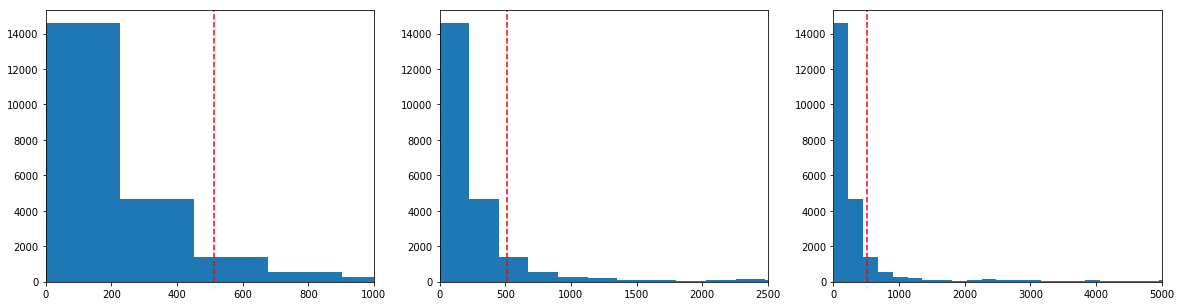

In [4]:
train_doc_lens = [len(doc.split(' ')) for doc in train_text]
f, ax = plt.subplots(1, 3, figsize=(20, 5))

ax[0].hist(train_doc_lens, bins=100)
ax[0].set_xlim([0, 1000])
ax[0].axvline(512, linestyle='--', color='r')

ax[1].hist(train_doc_lens, bins=100)
ax[1].set_xlim([0, 2500])
ax[1].axvline(512, linestyle='--', color='r')

ax[2].hist(train_doc_lens, bins=100)
ax[2].set_xlim([0, 5000])
ax[2].axvline(512, linestyle='--', color='r')

In [5]:
Counter([1 if ln > 512 else 0 for ln in train_doc_lens])

Counter({0: 19812, 1: 3430})

In [6]:
# Initialize session
sess = tf.Session()

# Params for bert model and tokenization
BERT_PATH = "models/model_assets/gokube-phase2/base_bert_tfhub_models/bert_uncased_L12_H768_A12"
MAX_SEQ_LENGTH = 512

In [7]:
# process text data
btp_train = btp.BertTextProcessor(tf_session=sess, 
                                  bert_model_path=BERT_PATH, 
                                  max_seq_length=MAX_SEQ_LENGTH)
btp_train.create_bert_tokenizer()
btp_train.convert_text_to_input_examples(train_text, train_labels)
btp_train.convert_examples_to_features()

Loading Base BERT Model
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0722 20:48:03.283648 140719148209984 tf_logging.py:115] Saver not created because there are no variables in the graph to restore
Converting text to examples: 23242it [00:00, 605558.47it/s]
Converting examples to features:   0%|          | 0/23242 [00:00<?, ?it/s]

Loading BERT WordPiece Tokenizer
Creating Input Examples from data
Creating BERT Input Features from Input Examples


Converting examples to features: 100%|██████████| 23242/23242 [06:26<00:00, 60.11it/s] 


In [8]:
# load pre-trained base BERT model
bc = bcvec.BERTClassifier(bert_model_path=BERT_PATH, 
                          max_seq_length=MAX_SEQ_LENGTH)
bc.build_model_architecture()
bc.model_estimator.summary()

Build BERT Classifier CVE Model Architecture
Loading Base BERT Model
Trainable layers: 199
Non Trainable layers: 5
Constructing Base BERT architecture
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0722 20:54:36.610916 140719148209984 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          (None, 512)          0                                            
__________________________________________________________________________________________________
input_masks (InputLayer)        (None, 512)          0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        (None, 512)          0                                            
__________________________________________________________________________________________________
bert_layer (BertLayer)          (None, 768)          110104890   input_ids[0][0]                  
                                                                 input_masks[0][0]                
          

In [9]:
class_weights = class_weight.compute_class_weight('balanced',
                                                  np.unique(btp_train.labels.ravel()),
                                                  btp_train.labels.ravel())
class_weights = dict(enumerate(class_weights))
class_weights[1] *= 2
class_weights

{0: 0.5148642062823978, 1: 34.63785394932936}

In [10]:
modelckpt_cb = tf.keras.callbacks.ModelCheckpoint('bert_cve99iter2_weights-ep:{epoch:02d}-trn_loss:{loss:.3f}-trn_acc:{acc:.3f}-val_loss:{val_loss:.3f}-val_acc:{val_acc:.3f}.h5', 
                                        save_weights_only=True, period=1, verbose=1)

In [11]:
btp.initialize_vars(sess)

In [12]:
history = bc.model_estimator.fit(x=[btp_train.input_ids, 
                                    btp_train.input_masks, 
                                    btp_train.segment_ids],
                                 y=train_labels,
                                 validation_split=0.1,
                                 epochs=5,
                                 batch_size=15,
                                 class_weight=class_weights,
                                 callbacks=[modelckpt_cb],
                                 verbose=1
)

/home/redanalyze/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 20917 samples, validate on 2325 samples
Epoch 1/5
20910/20917 [============================>.] - ETA: 0s - loss: 0.3755 - acc: 0.9063
Epoch 00001: saving model to bert_cve99_weights-ep:01-trn_loss:0.375-trn_acc:0.906-val_loss:0.278-val_acc:0.984.h5
20917/20917 [==============================] - 2794s 134ms/step - loss: 0.3754 - acc: 0.9063 - val_loss: 0.2784 - val_acc: 0.9837
Epoch 2/5
20910/20917 [============================>.] - ETA: 0s - loss: 0.1938 - acc: 0.9527
Epoch 00002: saving model to bert_cve99_weights-ep:02-trn_loss:0.194-trn_acc:0.953-val_loss:0.217-val_acc:0.948.h5
20917/20917 [==============================] - 2783s 133ms/step - loss: 0.1939 - acc: 0.9527 - val_loss: 0.2167 - val_acc: 0.9475
Epoch 3/5
20910/20917 [============================>.] - ETA: 0s - loss: 0.1114 - acc: 0.9764
Epoch 00003: saving model to bert_cve99_weights-ep:03-trn_loss:0.111-trn_acc:0.976-val_loss:0.308-val_acc:0.980.h5
20917/20917 [==============================] - 2776s 133ms/step 

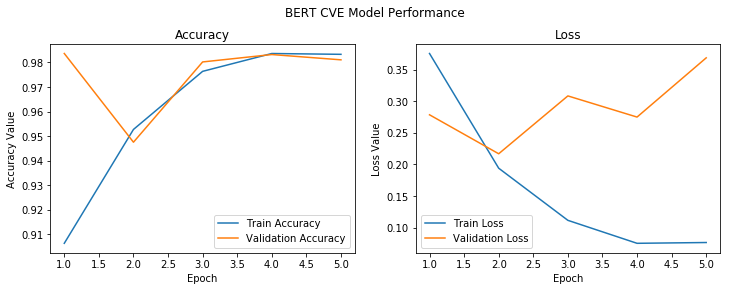

In [17]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('BERT CVE Model Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.2)

epochs = list(range(1,6))
ax1.plot(epochs, history.history['acc'], label='Train Accuracy')
ax1.plot(epochs, history.history['val_acc'], label='Validation Accuracy')
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epochs, history.history['loss'], label='Train Loss')
ax2.plot(epochs, history.history['val_loss'], label='Validation Loss')
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [18]:
import gc
del bc
gc.collect()

5497

In [20]:
bc = bcvec.BERTClassifier(bert_model_path=BERT_PATH, 
                          max_seq_length=MAX_SEQ_LENGTH)
bc.build_model_architecture()
bc.load_model_weights(model_weights_path='./bert_cve99_weights-ep:04-trn_loss:0.075-trn_acc:0.984-val_loss:0.275-val_acc:0.983.h5')
test_predictions = bc.model_estimator.predict(x=[btp_train.input_ids, 
                                                 btp_train.input_masks, 
                                                 btp_train.segment_ids],
                                                 batch_size=256,
                                              verbose=1)

Build BERT Classifier CVE Model Architecture
Loading Base BERT Model
Trainable layers: 199
Non Trainable layers: 5
Constructing Base BERT architecture
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0723 06:14:37.935068 140719148209984 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Loading BERT Classifier CVE Model Weights
23242/23242 [==============================] - 1136s 49ms/step


In [24]:
test_preds = test_predictions.ravel()
test_preds = [1 if pred > 0.5 else 0 for pred in test_preds]
print('Performance Report:')
print(classification_report(y_true=train_labels, y_pred=test_preds))
print(confusion_matrix(y_true=train_labels, y_pred=test_preds))

Performance Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     22571
           1       0.84      0.96      0.89       671

    accuracy                           0.99     23242
   macro avg       0.92      0.97      0.94     23242
weighted avg       0.99      0.99      0.99     23242

[[22445   126]
 [   30   641]]
